In [302]:
import datetime, os, sys, pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
from lambeq import NumpyModel, AtomicType, IQPAnsatz
from lambeq.backend.quantum import Ry, Diagram, Bra
from contextuality.model import Model, Scenario, CyclicScenario
from util import sent2dig
import tensornetwork as tn
from scipy.linalg import logm, sqrtm

In [303]:
class QModel(NumpyModel):
    def __init__(self, use_jit: bool = False) -> None:
        super().__init__(use_jit)

    def get_output_state(self, diagrams):
        diagrams = self._fast_subs(diagrams, self.weights)
        results = []
        for d in diagrams:
            assert isinstance(d, Diagram)
            result = tn.contractors.auto(*d.to_tn()).tensor
            result = np.array(result).flatten()
            result = np.sqrt(result/sum(abs(result)))
            results.append(result)
        return np.array(results)

In [330]:
models = {'disjoint_uncut': 'runs/disjoint_uncut_130E/best_model.lt', 
          'disjoint_cut': 'runs/disjoint_cut_140E/best_model.lt',
          'spider_uncut': 'runs/spider_uncut_200E/best_model.lt', 
          'spider_cut': 'runs/spider_cut_50E/best_model.lt'}

diagrams = {'disjoint_uncut': 'dataset/diagrams/disjoint_uncut.pkl',
            'disjoint_cut': 'dataset/diagrams/disjoint_cut.pkl',
            'spider_uncut': 'dataset/diagrams/spider_uncut.pkl',
            'spider_cut': 'dataset/diagrams/spider_cut.pkl'}

data = {'disjoint_uncut': 'dataset/contextuality_data/scenario442_disjoint_uncut.csv',
        'disjoint_cut': 'dataset/contextuality_data/scenario442_disjoint_cut.csv',
        'spider_uncut': 'dataset/contextuality_data/scenario422_spider_uncut.csv',
        'spider_cut': 'dataset/contextuality_data/scenario442_spider_cut.csv'}

In [305]:
N = AtomicType.NOUN
S = AtomicType.SENTENCE
P = AtomicType.PREPOSITIONAL_PHRASE

ansatz = IQPAnsatz({N: 1, S: 1, P:1}, n_layers=1, n_single_qubit_params=3) 

In [338]:
class data_processor:
    def __init__(self, scenario: Scenario, model_path: str=None):
        self.scenario = scenario # Measurement scenario modelling the schema

        # Data
        self.data = pd.DataFrame(columns=["Sentence", "CF", "SF", "CbD", "DI", "Violation", "Distribution"])
        self.diagrams = []
        self.sentences = []
            
        if model_path: # Model is a NumpyModel with learnt parameters of ansatz circuits
            self.model = QModel.from_checkpoint(model_path)
            self.model.initialise_weights()
        else:
            self.model = None

        # Measurement basis used in max violation CHSH experiment with their matrix representations
        self.bases = {'a':Ry(0), 'A':Ry(np.pi/4), 'b':Ry(np.pi/8), 'B':Ry(3*np.pi/8)}
        self.pairs = {'ab': np.kron(Ry(0).array, Ry(np.pi/8).array),
                      'aB': np.kron(Ry(0).array, Ry(3*np.pi/8).array),
                      'Ab': np.kron(Ry(np.pi/4).array, Ry(np.pi/8).array),
                      'AB': np.kron(Ry(np.pi/4).array, Ry(3*np.pi/8).array)}

    def load_file(self, path: str) -> None | pd.DataFrame | zip:
        if not path:
            return
        elif os.path.splitext(path)[-1] == '.csv':
            return pd.read_csv(path)
        elif os.path.splitext(path)[-1] == '.pkl':
            file = open(path, 'rb')
            data =  pickle.load(file)
            file.close()
            return data
        else:
            print("Provided file doesn't match a supported type.")
            return

    def load_model(self, path: str, variant: str=None) -> None:
        self.model = NumpyModel.from_checkpoint(model_path)

    def get_data(self, path: str) -> None:
        if not path:
            return
        self.data = self.load_file(path)

    def get_diagrams(self, path: str, cut=True) -> None:
        if not path:
            return
        
        schema_data = self.load_file(path)
        if os.path.splitext(path)[-1] == '.pkl':
            self.sentences, self.diagrams = zip(*schema_data)
            self.sentences = list(self.sentences)
            self.diagrams = list(self.diagrams)
            return
            
        for _, row in tqdm(schema_data.iterrows(), total=len(schema_data)):
            try:
                s1, s2, pro, ref = row[['sentence1','sentence2','pronoun','referent']]
                self.diagrams.append(ansatz(sent2dig(s1, s2, pro, ref, cut=cut)))
                self.sentences.append(s1 + '. ' + s2 + '.')
            except Exception as err:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
        f = open('dataset/sent_circ_pairs'+'_'+str(len(self.diagrams))+'_'+datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")+'.pkl', 'wb')
        pickle.dump(list(zip(self.sentences, self.diagrams)), f)
        f.close()

    def get_emp_model(self, diag: Diagram) -> Model:
        diag_ab = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['b'],1)
        diag_aB = diag.apply_gate(self.bases['a'],0).apply_gate(self.bases['B'],1)
        diag_Ab = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['b'],1)
        diag_AB = diag.apply_gate(self.bases['A'],0).apply_gate(self.bases['B'],1)

        pr_dist = self.model.get_diagram_output([diag_ab, diag_aB, diag_Ab, diag_AB])
        pr_dist = np.reshape(pr_dist, (4,4))
        return Model(self.scenario, pr_dist)

    def calc_violation(self, state: np.array) -> float:
        expectations = [np.matmul(np.conjugate(state), np.matmul(self.pairs[ops], state)) for ops in list(self.pairs.keys())]
        res = 0.0 + 0.0j
        for i in range(4):
            cur = abs(sum(expectations) - 2*expectations[i])
            #possible_vals.append(res)
            res = max(res, cur)
        return res

    def bipartide_partial_trace(self, dense_mat):
        # Compute reduced density matrix for a bipartide quantum system
        n_dim = dense_mat.shape[0]//2
        id_mat = np.identity(n_dim)
    
        res = np.zeros((n_dim, n_dim))
        for base in id_mat:
            bra = np.kron(id_mat, base)
            ket = np.kron(id_mat, base).T
            res = res + np.matmul(np.matmul(bra, dense_mat), ket)
        return res

    def log_mat(self, mat): # Matrix logarithm via eigendecomposition
        evals, emat = np.linalg.eig(mat) # Get matrix V of eigenvectors of input matrix A
        emat_inv = np.linalg.inv(emat) # Get inverse of matrix V
        matp = emat @ mat @ emat_inv # Compute A' with a diagonal of eigenvalues tr(A') = evals
        np.fill_diagonal(matp, np.log(matp.diagonal())) # Element wise natural log of diagonal
        return emat_inv @ matp @ emat # Change basis back

    def calc_vne(self, dense_mat):
        evals = np.linalg.eigvals(mat)
        evals = evals[np.abs(evals) > 1e-12]
        ent = -np.sum(evals * np.log(evals))
        if ent > 1e-12:
            return ent
        else:
            return 0

    def qrel_ent(self, mat1, mat2):
        evals1 = self.eigen_decompose(mat1)
        evals2 = self.eigen_decompose(mat2)
        return np.sum(evals1*(evals1 - evals2))

    def get_dense_mat(self, state, tol=1e-12):
        dense_mat = np.outer(state, np.conjugate(state))
        dense_mat.real[abs(dense_mat.real) < tol] = 0.0
        dense_mat.imag[abs(dense_mat.imag) < tol] = 0.0
        return dense_mat
    
    def gen_data(self) -> None:
        data_dict = {'Sentence':[], 'CF':[], 'SF':[], 'CbD':[], 'DI':[], 'Violation':[], 'Distribution': []}
        for diagram, sentence in tqdm(zip(self.diagrams, self.sentences), total=len(self.diagrams)):
            try:
                cur_emp_model = self.get_emp_model(diagram)
                
                data_dict['CF'].append(cur_emp_model.signalling_fraction())
                data_dict['SF'].append(cur_emp_model.contextual_fraction())
                data_dict['CbD'].append(cur_emp_model.CbD_measure())
                data_dict['DI'].append(cur_emp_model.CbD_direct_influence())
                data_dict['Distribution'].append(cur_emp_model._distributions)
                state = self.model.get_output_state([diagram])[0]
                data_dict['Violation'].append(self.calc_violation(state))
                data_dict['Sentence'].append(sentence)
            except Exception as err:
                tqdm.write(f"Error: {err}".strip(), file=sys.stderr)
        self.data = pd.DataFrame(data_dict)
        self.data.to_csv('dataset/scenario442_' + str(len(self.diagrams)) + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S") + '.csv')

    def plot_cnxt(self, title: str, save: bool=True) -> None:
        cf = self.data['CF'].to_numpy()
        sf = self.data['SF'].to_numpy()
        di = self.data['DI'].to_numpy()
        cmap = plt.get_cmap('viridis_r')
        cmap.set_under('red')
        scat = plt.scatter(x=cf, y=di, c=sf, cmap=cmap, vmax=1, vmin=1/6)
        plt.axvline(x=1/6, color='r', linestyle='-')
        plt.axhline(y=2, color='r', linestyle='-')
        plt.text(x=1/6+0.05,y=5,s='Sheaf Contextual')
        plt.text(x=0.7,y=1.5,s='CbD Contextual')
        plt.xlabel('Contextual Fraction')
        plt.ylabel('Direct Influence')
        plt.colorbar(label='Signalling Fraction', extend='min')
        plt.title(title)
        scat.set_alpha(0.5)
        scat.cmap.set_over('red')
        if save:
            plt.savefig('figures/' + title + '_' + datetime.datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
        plt.show()

In [339]:
test = data_processor(scenario=CyclicScenario(['a','b','A','B'],2),
                      model_path=models['spider_cut'])

In [340]:
test.get_data(data['spider_cut'])
test.get_diagrams(diagrams['spider_cut'])

In [341]:
x = test.data['CF']
y = test.data['Violation']
z = test.data['SF']

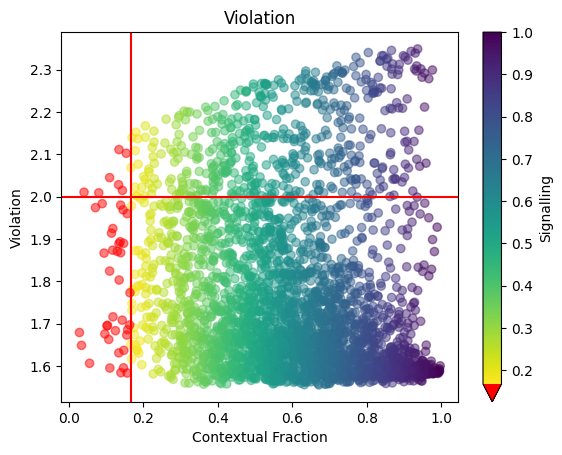

In [349]:
cmap = plt.get_cmap('viridis_r')
cmap.set_under('red')
scat = plt.scatter(x=x, y=y, c=z, alpha=1, vmax=1, vmin=1/6, cmap=cmap)
plt.xlabel('Contextual Fraction')
plt.ylabel('Violation')
plt.axvline(x=1/6, color='r', linestyle='-')
plt.axhline(y=2, color='r', linestyle='-')
plt.colorbar(label='Signalling', extend='min')
plt.title('Violation')
scat.set_alpha(0.5)
scat.cmap.set_under('red')
plt.show()

In [132]:
eoe = []
qre = []
for diagram in tqdm(test.diagrams):
    try:
        #dist = test.model.get_diagram_output([diagram])[0].flatten()
        #state = np.sqrt(dist)
        state = test.model.get_output_state([diagram])[0]
        dense_mat = test.get_dense_mat(state)
        reduced_dense_mat = test.bipartide_partial_trace(dense_mat)
        eoe.append(test.calc_vne(reduced_dense_mat))

        diag1 = diagram.apply_gate(Bra(0),0)
        diag2 = diagram.apply_gate(Bra(0),1)
        state1 = test.model.get_output_state([diag1])[0]
        state2 = test.model.get_output_state([diag2])[0]
        mat1 = test.get_dense_mat(state1)
        mat2 = test.get_dense_mat(state2)
        qre.append(test.qrel_ent(mat1, mat2))
    except Exception as err:
        tqdm.write(f"Error: {err}".strip(), file=sys.stderr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3057/3057 [03:38<00:00, 14.02it/s]


In [166]:
state = np.array([1,0,0,0,0,0,0,1],dtype=np.cdouble)*np.sqrt(1/2)
dense_mat = test.get_dense_mat(state)
reduced_dense_mat = test.bipartide_partial_trace(dense_mat)
discut.calc_vne(reduced_dense_mat)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 16)

In [315]:
def bipartide_partial_trace(dense_mat):
    # Compute reduced density matrix for a bipartide quantum system
    dims_a = int(2**(np.floor(np.log2(dense_mat.shape[0])/2)))
    dims_b = int(2**(np.ceil(np.log2(dense_mat.shape[0])/2)))
    id_a = np.identity(dims_a)
    id_b = np.identity(dims_b)

    rho_a = np.zeros((dims_a, dims_a))
    rho_b = np.zeros((dims_b, dims_b))

    for base in id_b:
        bra = np.kron(id_mat_a, base)
        ket = np.kron(id_mat_a, base).T
        rho_a = rho_a + np.matmul(np.matmul(bra, dense_mat), ket)
    for base in id_a:
        bra = np.kron(id_mat_b, base)
        ket = np.kron(id_mat_b, base).T
        rho_b = rho_b + np.matmul(np.matmul(bra, dense_mat), ket)
    return res

In [316]:
def log_mat(mat): # Matrix logarithm via eigendecomposition
    evals, emat = np.linalg.eig(mat) # Get matrix V of eigenvectors of input matrix A
    emat_inv = np.linalg.inv(emat) # Get inverse of matrix V
    matp = emat @ mat @ emat_inv # Compute A' with a diagonal of eigenvalues tr(A') = evals
    np.fill_diagonal(matp, np.log(matp.diagonal())) # Element wise natural log of diagonal
    return emat_inv @ matp @ emat # Change basis back

In [317]:
def get_dense_mat(state, tol=1e-12):
    dense_mat = np.outer(state, np.conjugate(state))
    dense_mat.real[abs(dense_mat.real) < tol] = 0.0
    dense_mat.imag[abs(dense_mat.imag) < tol] = 0.0
    return dense_mat

In [290]:
state = np.array([1,0,0,1],dtype=np.cdouble)*np.sqrt(1/2)


In [297]:
def log_mat(mat): # Matrix logarithm via eigendecomposition
    evals, emat = np.linalg.eig(mat) # Get matrix V of eigenvectors of input matrix A
    emat_inv = np.linalg.inv(emat) # Get inverse of matrix V
    matp = emat @ mat @ emat_inv # Compute A' with a diagonal of eigenvalues tr(A') = evals
    np.fill_diagonal(matp, np.log(matp.diagonal())) # Element wise natural log of diagonal
    return emat_inv @ matp @ emat # Change basis back

In [301]:
print(-np.trace(dense_a @ log_mat(dense_a)))

(0.6931471805599452-0j)


In [ ]:
print(-np.trace(dense_a @ log_mat(dense_b)))

In [291]:
evals = np.linalg.eigvals(dense_a)
evals = evals[np.abs(evals) > 1e-12]
ent_a = -np.sum(evals * np.log(evals))

In [292]:
evals = np.linalg.eigvals(dense_b)
evals = evals[np.abs(evals) > 1e-12]
ent_b = -np.sum(evals * np.log(evals))

In [293]:
print(ent_a)
print(ent_b)

(0.6931471805599452-0j)
(0.6931471805599452-0j)
